In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from dataset import LayoutDataset
from models import LayoutMLP
from scipy.stats import kendalltau

2023-11-01 21:45:18.503230: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-01 21:45:19.132604: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
batch_size = 128
learning_rate = 8e-4
batch_per_file_size = 8
node_embedding_size = 10
layers = [32, 16, 32, 16]

dataset = LayoutDataset(
    batch_size, train_sample_fraction=1.0,
    subset=None, build_tfrecords=False,
    batch_per_file_size=batch_per_file_size
)

2023-11-01 21:45:20.344535: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-01 21:45:20.379597: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-01 21:45:20.379845: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
mlp = LayoutMLP(
    batch_size,
    learning_rate=learning_rate,
    mask_max_len=dataset.n_config_nodes_upper_limit,
    batch_per_file_size=batch_per_file_size,
    node_embedding_size=node_embedding_size,
    validation_frequency=10_000,
    validations_without_improvement=5,
    layer_sizes=layers,
    loss='pairwise_hinge',
    l1_multiplier=1e-9,
    n_siblings=dataset.n_siblings
)

In [4]:
for batch in dataset.train_data:
    print(batch.keys())
    break

dict_keys(['config_index', 'graph_descriptor', 'layout_id', 'node_descriptor', 'target', 'valid_nodes'])


In [5]:
node_descriptor = batch['node_descriptor']
node_descriptor

<tf.Tensor: shape=(128, 1000, 149), dtype=float32, numpy=
array([[[0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         7.500e+01],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         7.500e+01],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         7.500e+01],
        ...,
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00]],

       [[0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         7.500e+01],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         7.500e+01],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         7.500e+01],
        ...,
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000

In [6]:
node_descriptor_shapes = tf.gather(
    node_descriptor,
    mlp.features_with_dims,
    axis=-1)

new_order = tf.concat([
    mlp.siblings_order,
    mlp.node_order,
    mlp.parents_order
], axis=0)
new_order = tf.gather(
    node_descriptor,
    new_order,
    axis=-1
)
new_order = tf.cast(new_order, tf.int32)

reordered_shape_list = []
for i in range(1+2+mlp.n_siblings):
    reordered_shapes = tf.gather(
        node_descriptor_shapes[:, :, i*6:(i+1)*6],
        new_order[:, :, i*6:(i+1)*6],
        axis=2,
        batch_dims=2
    )
    reordered_shape_list.append(reordered_shapes)
reordered_shapes = tf.concat(reordered_shape_list, axis=-1)
reordered_shapes

<tf.Tensor: shape=(128, 1000, 36), dtype=float32, numpy=
array([[[0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        ...,
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00]],

       [[0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        ...,
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e

In [7]:
batch_i = 120
batch['layout_id'][batch_i]

<tf.Tensor: shape=(), dtype=string, numpy=b'layout:xla:default:efficientnet_b7_eval_batch_1'>

In [8]:
node = 32
print(
    reordered_shapes[batch_i, node, :].numpy().reshape(-1, 6), '\n'*2, 
    node_descriptor_shapes[batch_i, node, :].numpy().astype(int).reshape(-1, 6),'\n'*2,
    new_order[batch_i, node, :].numpy().reshape(-1, 6))

[[6.40e+02 2.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [6.40e+02 3.84e+03 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [3.84e+03 2.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [6.40e+02 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [1.90e+01 6.40e+02 0.00e+00 0.00e+00 0.00e+00 0.00e+00]] 

 [[   2   19   19  640    0    0]
 [   1    1 3840  640    0    0]
 [   0    0    0    0    0    0]
 [   2   19   19 3840    0    0]
 [   1    1 3840  640    0    0]
 [   2   19   19  640    0    0]] 

 [[ 3  0 -1 -1 -1 -1]
 [ 3  2 -1 -1 -1 -1]
 [ 0  0  0  0  0  0]
 [ 3  0 -1 -1 -1 -1]
 [ 3  0 -1 -1 -1 -1]
 [ 2  3 -1 -1 -1 -1]]


In [9]:
mlp.train(dataset, None)

2023-11-01 21:47:14.063433: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-01 21:47:14.134674: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9fd909b5c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-01 21:47:14.134697: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2023-11-01 21:47:14.176994: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-01 21:47:14.424345: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-01 21:47:14.620714: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

iteration 500 training loss 3.2424967 lr 0.00004
iteration 1000 training loss 2.8148887 lr 0.00008
iteration 1500 training loss 3.1638734 lr 0.00012
iteration 2000 training loss 2.457754 lr 0.00016
iteration 2500 training loss 2.5201664 lr 0.00020
iteration 3000 training loss 2.149992 lr 0.00024
iteration 3500 training loss 1.6357596 lr 0.00028
iteration 4000 training loss 1.7347398 lr 0.00032
iteration 4500 training loss 1.7975025 lr 0.00036
iteration 5000 training loss 1.4910494 lr 0.00040
iteration 5500 training loss 1.8172158 lr 0.00044
iteration 6000 training loss 1.6492391 lr 0.00048
iteration 6500 training loss 1.6529721 lr 0.00052
iteration 7000 training loss 1.7674599 lr 0.00056
iteration 7500 training loss 1.7215682 lr 0.00060
iteration 8000 training loss 1.9002025 lr 0.00064
iteration 8500 training loss 1.8841289 lr 0.00068
iteration 9000 training loss 1.4934773 lr 0.00072
iteration 9500 training loss 1.832401 lr 0.00076
iteration 10000 training loss 1.5761915 lr 0.00080
lay

iteration 70000 training loss 1.4864426 lr 0.00069
layout:nlp:random 0.879460026779965
layout:nlp:default 0.46758564941766706
layout:xla:random 0.5941167881908411
layout:xla:default 0.25857373753056495
epoch 0, it 70000 validation loss -0.550
iteration 70500 training loss 1.3863274 lr 0.00069
iteration 71000 training loss 1.1048969 lr 0.00069
iteration 71500 training loss 1.3125335 lr 0.00069
iteration 72000 training loss 1.5782093 lr 0.00069
iteration 72500 training loss 1.0115217 lr 0.00068
iteration 73000 training loss 1.2589831 lr 0.00068
iteration 73500 training loss 1.6666594 lr 0.00068
iteration 74000 training loss 1.0033354 lr 0.00068
iteration 74500 training loss 1.579684 lr 0.00068
iteration 75000 training loss 1.049846 lr 0.00068
iteration 75500 training loss 1.4596131 lr 0.00067
iteration 76000 training loss 0.9917902 lr 0.00067
iteration 76500 training loss 1.2391195 lr 0.00067
iteration 77000 training loss 1.4909021 lr 0.00067
iteration 77500 training loss 0.8681824 lr 0.

iteration 136500 training loss 1.5859743 lr 0.00040
iteration 137000 training loss 0.8994 lr 0.00039
iteration 137500 training loss 1.0602666 lr 0.00039
iteration 138000 training loss 1.5311296 lr 0.00039
iteration 138500 training loss 1.1304369 lr 0.00039
iteration 139000 training loss 0.9902952 lr 0.00038
iteration 139500 training loss 0.87232906 lr 0.00038
iteration 140000 training loss 0.5916969 lr 0.00038
layout:nlp:random 0.8855802081656268
layout:nlp:default 0.47972499913864886
layout:xla:random 0.6179405825755816
layout:xla:default 0.2818768832774213
epoch 0, it 140000 validation loss -0.566
iteration 140500 training loss 1.206051 lr 0.00038
iteration 141000 training loss 0.9952798 lr 0.00037
iteration 141500 training loss 1.0696048 lr 0.00037
iteration 142000 training loss 1.0400739 lr 0.00037
iteration 142500 training loss 0.8335541 lr 0.00037
iteration 143000 training loss 1.0674729 lr 0.00036
iteration 143500 training loss 1.3688775 lr 0.00036
iteration 144000 training loss

iteration 202500 training loss 1.0101621 lr 0.00011
iteration 203000 training loss 1.4798272 lr 0.00011
iteration 203500 training loss 1.0327657 lr 0.00010
iteration 204000 training loss 1.2621633 lr 0.00010
iteration 204500 training loss 1.87892 lr 0.00010
iteration 205000 training loss 0.8516628 lr 0.00010
iteration 205500 training loss 1.1002429 lr 0.00010
iteration 206000 training loss 1.2687457 lr 0.00010
iteration 206500 training loss 1.1531988 lr 0.00009
iteration 207000 training loss 0.6994094 lr 0.00009
iteration 207500 training loss 1.0924312 lr 0.00009
iteration 208000 training loss 0.77750945 lr 0.00009
iteration 208500 training loss 1.1818161 lr 0.00009
iteration 209000 training loss 1.166386 lr 0.00009
iteration 209500 training loss 1.5441409 lr 0.00009
iteration 210000 training loss 1.1652031 lr 0.00008
layout:nlp:random 0.8950585990706834
layout:nlp:default 0.4794532627444513
layout:xla:random 0.6589339300785229
layout:xla:default 0.2921791331790318
epoch 0, it 210000 v

layout:nlp:random 0.9148039187486727
layout:nlp:default 0.4991596050315943
layout:xla:random 0.6529298372607649
layout:xla:default 0.3197399789608818
epoch 0, it 270000 validation loss -0.597
iteration 270500 training loss 1.4258275 lr 0.00001
iteration 271000 training loss 0.9917835 lr 0.00001
iteration 271500 training loss 1.3827254 lr 0.00001
iteration 272000 training loss 0.80225855 lr 0.00001
iteration 272500 training loss 1.3021808 lr 0.00001
iteration 273000 training loss 1.288849 lr 0.00001
iteration 273500 training loss 1.085331 lr 0.00001
iteration 274000 training loss 1.3491849 lr 0.00001
iteration 274500 training loss 1.2030666 lr 0.00001
iteration 275000 training loss 1.210657 lr 0.00001
iteration 275500 training loss 0.846557 lr 0.00001
iteration 276000 training loss 0.9903362 lr 0.00001
iteration 276500 training loss 0.92395073 lr 0.00001
iteration 277000 training loss 1.4132808 lr 0.00001
iteration 277500 training loss 1.4622726 lr 0.00001
iteration 278000 training loss

## Evaluate validation set

In [10]:
val_df = mlp.predict_over_dataset(dataset.valid_data, return_labels=True)

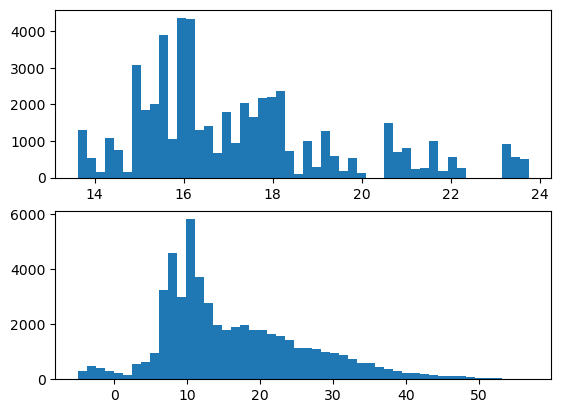

In [11]:
plt.subplot(2, 1, 1)
plt.hist(val_df['target'], bins=50)
plt.subplot(2, 1, 2)
plt.hist(val_df['prediction'], bins=50);

In [12]:
val_df.groupby('ID').apply(lambda x: x.min()).sort_values('prediction')

,ID,config_index,prediction,target
ID,,,,
b'layout:xla:default:resnet_v1_50_official_batch_128_bf16',b'layout:xla:default:resnet_v1_50_official_bat...,6,-4.995913,20.910105
b'layout:xla:default:resnet50.4x4.fp16',b'layout:xla:default:resnet50.4x4.fp16',22,-4.887241,19.288330
b'layout:xla:random:resnet50.4x4.fp16',b'layout:xla:random:resnet50.4x4.fp16',9,-3.766685,19.288380
b'layout:xla:random:resnet_v1_50_official_batch_128_bf16',b'layout:xla:random:resnet_v1_50_official_batc...,8,-1.703213,20.910069
b'layout:xla:default:inception_v3_batch_128_train',b'layout:xla:default:inception_v3_batch_128_tr...,3,0.170058,21.680357
b'layout:xla:random:inception_v3_batch_128_train',b'layout:xla:random:inception_v3_batch_128_train',3,3.376916,21.680561
b'layout:xla:default:bert_pretraining.4x4.fp16',b'layout:xla:default:bert_pretraining.4x4.fp16',30,4.075350,17.647287
b'layout:xla:default:tf2_bert_pretrain_dynamic_batch_size',b'layout:xla:default:tf2_bert_pretrain_dynamic...,32,4.220967,17.943735
b'layout:nlp:default:bert_multi_cased_L-12_H-768_A-12_batch_size_16_train',b'layout:nlp:default:bert_multi_cased_L-12_H-7...,46,5.669765,17.403856


Text(0.5, 1.0, "b'layout:nlp:default:small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_64_train'")

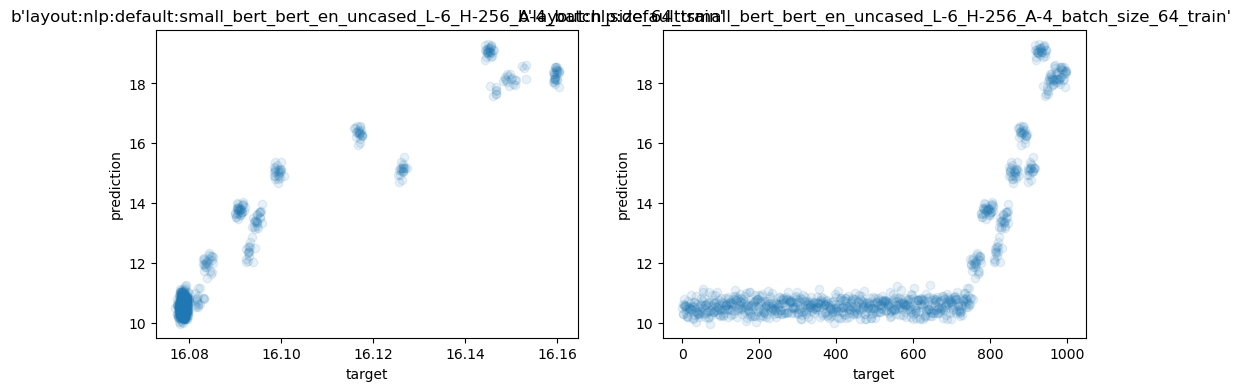

In [16]:
x_lin = np.linspace(15, 25, 100)
#plt.plot(x_lin, x_lin, color='orange')

random_sample = val_df.sample(1_000)
graph_id = np.random.choice(val_df['ID'].unique())
#graph_id = b'layout:xla:default:inception_v3_batch_128_train'
#graph_id = b'layout:xla:default:unet_3d.4x4.bf16'
random_sample = val_df[val_df['ID'] == graph_id].copy()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(
    random_sample.target,
    np.clip(random_sample.prediction, a_min=-500.0, a_max=1000.0),
    alpha=0.1,
    #c=random_sample['ID'].apply(lambda x: x.decode('UTF-8').split(':')[1] == 'xla').values.astype(float)
)
plt.xlabel('target')
plt.ylabel('prediction')
plt.title(graph_id)
#plt.colorbar()

random_sample.sort_values('target', inplace=True)
plt.subplot(1, 2, 2)
plt.scatter(
    np.arange(len(random_sample)),
    np.clip(random_sample.prediction, a_min=-500.0, a_max=1000.0),
    alpha=0.1,
    #c=random_sample['ID'].apply(lambda x: x.decode('UTF-8').split(':')[1] == 'xla').values.astype(float)
)
plt.xlabel('target')
plt.ylabel('prediction')
plt.title(graph_id)
#plt.colorbar()

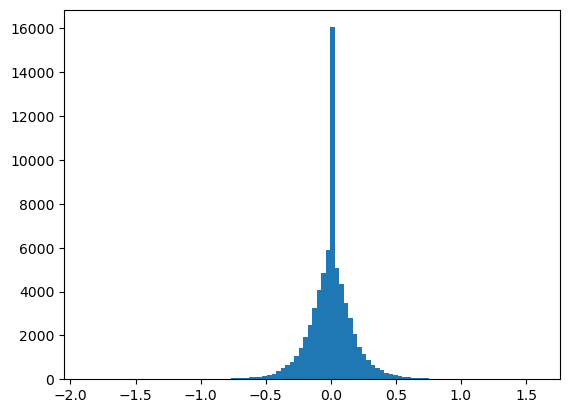

In [14]:
plt.hist(mlp.k_layer.kernel.numpy().flatten(), bins=100);

ValueError: cannot reshape array of size 68832 into shape (203,12,newaxis)

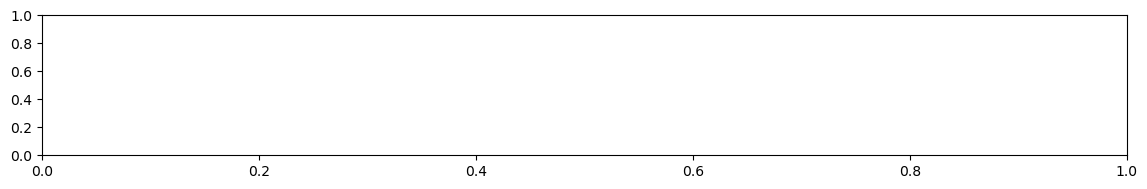

In [15]:
plt.figure(figsize=(14, 4))
kind = 1
plt.subplot(2, 1, 1)
k_vals = mlp.k_layer.kernel.numpy().reshape(203, 12, -1)[:, kind, :].T
plt.imshow(k_vals)

plt.subplot(2, 1, 2)
q_vals = mlp.q_layer.kernel.numpy().reshape(203, 12, -1)[:, kind, :].T
plt.imshow(q_vals)

00        interesting features (20)
            np.arange(21, 27),  # shape dims
            np.arange(31, 37),  # reshape/broadcast dims
            np.arange(95, 99),  # conv dims input
            np.arange(101, 105),  # conv dims kernel
20        parent output shapes (12)
32        sibling shapes (n_siblings*6)
50        physical layout (6)
56        node layout (18)
74        parent phys layout (12)
86        siblings layout (n_sibling*18)
140        parent opcodes (2)
164        sibling opcodes (n_siblings)
200        opcode (1)

In [ ]:
lens = [20, 12, 18, 6, 18, 12, 18*3, 24, 36, 12]
np.cumsum(lens)

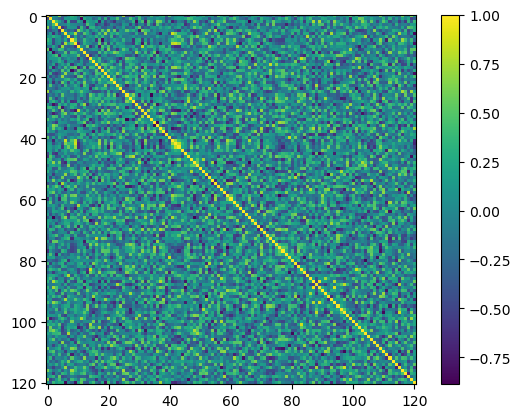

In [17]:
emb = mlp.embedding_layer_node_ops.weights[0].numpy()
emb = emb / np.expand_dims(np.linalg.norm(emb, axis=1), axis=-1)
dots = np.matmul(emb, emb.T)
plt.imshow(dots)
plt.colorbar()

In [ ]:
dots[34, 26]

In [ ]:
np.argsort(dots[26])

In [ ]:
ind = np.unravel_index(np.argsort(dots.flatten())[-122], dots.shape)
ind

In [ ]:
val_df[val_df['ID'] == b'layout:xla:default:unet_3d.4x4.bf16'].sort_values('target')

In [ ]:
for val_batch in dataset.valid_data:
    if b'layout:xla:default:mlperf_bert_batch_24_2x2' in val_batch['layout_id'].numpy():
        print(val_batch['layout_id'])
        break

In [ ]:
np.unique(val_batch['layout_id'].numpy())

In [ ]:
b'layout:xla:default:mlperf_bert_batch_24_2x2' in val_batch['layout_id'].numpy()

In [ ]:
layout_ids = val_batch['layout_id']
config_descriptor = val_batch['node_descriptor']
valid_mask = val_batch['valid_nodes']
graph_descriptor = val_batch['graph_descriptor']

with tf.device('/cpu:0'):
    subset_info_str = tf.map_fn(
        lambda layout_id: tf.strings.reduce_join(
            tf.strings.split(layout_id, ":")[:3]),
        layout_ids
    )

subset_info = mlp.text_vectorization(subset_info_str)
subset_info = tf.expand_dims(subset_info, axis=-1)
subset_info = mlp.embedding_layer_subset_info(subset_info)
subset_info = subset_info[:, 0, :]

# for si, sn in zip(subset_info_str.numpy(), subset_info.numpy()):
#     print(si, sn)

node_operations = config_descriptor[:, :, -1]
config_descriptor = config_descriptor[:, :, :-1]
node_operations = tf.cast(node_operations, tf.int32)
# node_operations.shape == (batch_size, mask_max_len)                                                                                                                                 
node_embedding = mlp.embedding_layer_node_ops(node_operations)
# node_embedding.shape == (batch_size, mask_max_len, embed_len)
# np.unique(node_operations.numpy().flatten(), return_counts=True)

x = mlp.normalization_layer_config_nodes(config_descriptor)
normal_graph_descriptor = mlp.normalization_layer_graph_descriptor(graph_descriptor)
x = tf.concat([x, node_embedding], axis=-1)

x = mlp.dense_layer_node_1(x)
x = mlp.relu_layer(x)  # (batch_size, n_config_nodes_upper_limit, n_units)                                                                                                           
x = mlp.dense_layer_node_2(x)
x = mlp.relu_layer(x)  # (batch_size, n_config_nodes_upper_limit, n_units)                                                                                                           

# plt.hist(x.numpy().flatten(), bins=100);
float_mask = tf.sequence_mask(valid_mask, mlp.mask_max_len, dtype=tf.float32)
# (batch_size, n_config_nodes_upper_limit)                                                                                                                                            

float_mask = tf.expand_dims(float_mask, axis=-1)
x = x * float_mask

x = tf.reduce_sum(x, axis=1)
#plt.subplot(2, 1, 1)
#plt.hist(x.numpy().flatten(), bins=100);

x = x / tf.expand_dims(tf.cast(valid_mask, tf.float32), axis=-1)
#plt.subplot(2, 1, 2)
#plt.hist(x.numpy().flatten(), bins=100);
for i, lid, gd, nd in zip(range(96), layout_ids.numpy(), graph_descriptor.numpy(), normal_graph_descriptor.numpy()):
    if i in [19]:
        print(i, gd[80:90], nd[80:90], lid)
x = tf.concat([x, normal_graph_descriptor, subset_info], axis=-1)
#plt.hist(x.numpy().flatten(), bins=100);
x = mlp.dense_layer_global_1(x)
x = mlp.relu_layer(x)
#plt.hist(x.numpy().flatten(), bins=100);
x = mlp.dense_layer_global_2(x)
x = mlp.relu_layer(x)
#plt.hist(x.numpy().flatten(), bins=100);
x = mlp.dense_layer_global_3(x)
x = tf.reshape(x, (-1,))
x

In [ ]:
random_sample = val_df.sample(5_000)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(
    random_sample['target'],
    np.abs(random_sample['target'] - random_sample['prediction']),
    alpha=0.07
)
plt.xlabel('target')
plt.ylabel('abs error')
x_lin = np.linspace(0, 0.7, 100)
#plt.plot(x_lin, x_lin, color='orange')


plt.subplot(1, 2, 2)
plt.scatter(
    random_sample['target'],
    np.square(random_sample['target'] - random_sample['prediction']),
    alpha=0.07
)
plt.xlabel('target')
plt.ylabel('squared error')

In [18]:
def sort_configs(df):
    top = df.sort_values('prediction')
    top = top['config_index'].values.tolist()
    top = [str(i) for i in top]
    return ';'.join(top)

val_prediction = val_df.groupby('ID').apply(sort_configs)
val_prediction.rename(index=lambda x: x.decode('UTF-8'), inplace=True)
val_prediction

ID
layout:nlp:default:albert_en_xlarge_batch_size_16_test                               38930;38944;50128;33561;50173;50151;15814;2794...
layout:nlp:default:bert_en_cased_L-12_H-768_A-12_batch_size_16_test                  72956;74217;81111;35919;48568;18748;78363;7753...
layout:nlp:default:bert_multi_cased_L-12_H-768_A-12_batch_size_16_train              15764;22819;8006;22875;8045;22896;2299;22831;2...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_32_test      76611;52863;53849;1866;13022;81508;8879;55557;...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_64_train     21797;7075;37606;9242;38956;38953;33074;47544;...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_32_test      4951;59153;31085;36444;4692;27961;92674;72191;...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_64_train     1050;515;523;548;1093;1036;25321;1292;1199;257...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H

In [19]:
val_df

,ID,config_index,prediction,target
0,b'layout:nlp:random:small_bert_bert_en_uncased...,5613,40.606342,16.077200
1,b'layout:nlp:random:small_bert_bert_en_uncased...,6493,37.070232,16.064095
2,b'layout:nlp:random:small_bert_bert_en_uncased...,7446,19.793343,15.917189
3,b'layout:nlp:random:small_bert_bert_en_uncased...,19349,39.484875,16.072752
4,b'layout:nlp:random:small_bert_bert_en_uncased...,3252,42.424374,16.089550
...,...,...,...,...
53476,b'layout:xla:default:unet_3d.4x4.bf16',1045,10.511457,20.629957
53477,b'layout:xla:default:unet_3d.4x4.bf16',1912,10.514846,20.629961
53478,b'layout:xla:default:unet_3d.4x4.bf16',1218,10.498480,20.645945
53479,b'layout:xla:default:unet_3d.4x4.bf16',218,12.831770,20.629946


In [20]:
val_df['ID'].map(lambda x: ':'.join(x.decode('UTF-8').split(':')[:3])).unique()

array(['layout:nlp:random', 'layout:nlp:default', 'layout:xla:random',
       'layout:xla:default'], dtype=object)

In [21]:
def compute_layout_score_group(df):
    score, _ = kendalltau(df['prediction'], df['target'])
    return score

val_df['subset'] = val_df['ID'].map(lambda x: ':'.join(x.decode('UTF-8').split(':')[:3]))
for subset in val_df['subset'].unique():
    mean = np.mean(val_df[val_df['subset'] == subset].groupby('ID').apply(compute_layout_score_group))
    print(subset, mean)

layout:nlp:random 0.9135194849023682
layout:nlp:default 0.49502333703765433
layout:xla:random 0.651335817270318
layout:xla:default 0.3208780550196724


In [22]:
np.mean([0.4185, 0.8167, 0.538, 0.2525])

0.506425

In [23]:
val_scores = val_df.groupby('ID').apply(compute_layout_score_group)
val_scores.sort_values()

ID
b'layout:xla:default:unet_3d.4x4.bf16'                                                  0.068113
b'layout:xla:random:unet_3d.4x4.bf16'                                                   0.226165
b'layout:xla:default:mlperf_bert_batch_24_2x2'                                          0.237803
b'layout:xla:random:mlperf_bert_batch_24_2x2'                                           0.247720
b'layout:xla:default:resnet_v1_50_official_batch_128_bf16'                              0.285880
b'layout:xla:default:tf2_bert_pretrain_dynamic_batch_size'                              0.331439
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-512_A-8_batch_size_64_test'      0.353366
b'layout:xla:default:inception_v3_batch_128_train'                                      0.377829
b'layout:nlp:default:small_bert_bert_en_uncased_L-4_H-512_A-8_batch_size_32_train'      0.386943
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_64_train'     0.409081
b'layout:xla:default:bert_p

In [ ]:
def layout_score(candidate_order, layout_dict):
    runtimes = layout_dict['config_runtime']
    best_ranking = np.argsort(runtimes)
    assert len(candidate_order) == len(runtimes)
    score, _ = kendalltau(candidate_order, best_ranking)
    return score

In [ ]:
dirpath, filename

In [ ]:
true_order = np.argsort(layout_dict['config_runtime'])
plt.scatter(true_order, candidate_order)

In [ ]:
layout_set = 'valid'
true_orders = []
layout_ids = []
for dirpath, dirnames, filenames in os.walk('predict-ai-model-runtime/npz_all/npz/layout'):
    if len(filenames) == 0:
        continue
    
    if dirpath.split('/')[-1] != layout_set:
        continue
        
    layout_id_prefix = ':'.join(dirpath.split('/')[-4:-1])
    for filename in os.listdir(dirpath):
        print(filename)
        layout_id = layout_id_prefix+':'+filename[:-4]
        layout_dict = dict(np.load(os.path.join(dirpath, filename)))
        runtimes = layout_dict['config_runtime']
        best_ranking = np.argsort(runtimes)
        best_ranking = ';'.join([str(i) for i in best_ranking])
        true_orders.append(best_ranking)
        layout_ids.append(layout_id)
        
true_order_df = pd.DataFrame(
    data=np.stack([layout_ids, true_orders], axis=-1),
    columns=['ID', 'true_order']
)
true_order_df

In [ ]:
# layout_id = true_order_df.sample()['ID'].values[0]
layout_id = 'layout:xla:default:resnet50.4x4.fp16'
true_order = [int(i) for i in true_order_df[true_order_df['ID'] == layout_id]['true_order'].values[0].split(';')]
candidate_order = [int(i) for i in val_prediction[layout_id].split(';')]

plt.scatter(true_order, candidate_order)
plt.xlabel('true order')
plt.ylabel('candidate order')
plt.title(f'{layout_id}, len {len(true_order)}')

In [ ]:
layout_dict = dict(np.load('predict-ai-model-runtime/npz_all/npz/layout/nlp/default/valid/small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train.npz'))
layout_dict['node_config_feat'].shape

In [ ]:
val_df[val_df['ID'] == b'layout:nlp:default:small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train']

In [ ]:
evaluation_result_layout['score'].astype(float).mean()

## Inference over test set

In [24]:
test_df = mlp.predict_over_dataset(dataset.test_data, return_labels=False)
test_df

,ID,config_index,prediction
0,b'layout:nlp:random:6c1101f6231f4d1722c3b9f6d1...,8,20.796177
1,b'layout:nlp:random:6c1101f6231f4d1722c3b9f6d1...,3,24.095798
2,b'layout:nlp:random:6c1101f6231f4d1722c3b9f6d1...,13,27.899948
3,b'layout:nlp:random:6c1101f6231f4d1722c3b9f6d1...,14,21.524876
4,b'layout:nlp:random:6c1101f6231f4d1722c3b9f6d1...,1,22.074039
...,...,...,...
49997,b'layout:nlp:default:6c1101f6231f4d1722c3b9f6d...,992,13.659142
49998,b'layout:nlp:default:6c1101f6231f4d1722c3b9f6d...,973,13.916741
49999,b'layout:nlp:default:6c1101f6231f4d1722c3b9f6d...,976,11.254206
50000,b'layout:nlp:default:6c1101f6231f4d1722c3b9f6d...,997,16.904846


In [25]:
test_prediction = test_df.groupby('ID').apply(sort_configs)
test_prediction.rename(index=lambda x: x.decode('UTF-8'), inplace=True)
test_prediction

ID
layout:nlp:default:016ac66a44a906a695afd2228509046a    30;681;557;844;841;663;659;198;558;529;947;683...
layout:nlp:default:171b0513d8874a427ccfa46d136fbadc    919;252;865;394;43;386;470;149;935;132;727;855...
layout:nlp:default:23559853d9702baaaacbb0c83fd32266    669;87;234;704;461;215;785;763;715;987;778;728...
layout:nlp:default:29886a50d55cfe77a9497bc906c76ce9    196;191;677;460;553;88;34;974;275;877;129;13;6...
layout:nlp:default:32531d07a084b319dce484f53a4cf3fc    487;224;313;371;327;220;630;141;513;895;990;63...
layout:nlp:default:38524e2ff135ded55b5286407e7af6b7    168;376;197;18;783;575;273;387;791;59;762;163;...
layout:nlp:default:3a0c5517a87df8d82fd637b83298a3ba    85;129;77;692;964;219;79;862;347;55;229;625;48...
layout:nlp:default:492c7a94d559aa4a88769142d2a68362    766;4;843;324;770;514;623;931;885;483;295;571;...
layout:nlp:default:58cc2e418c3a8a19b871e15964b534ad    879;581;572;743;166;328;679;584;37;44;131;231;...
layout:nlp:default:60880ed76de53f4d7a1b960b24f20f7d 

In [26]:
pd.DataFrame(test_prediction, columns=['TopConfigs']).to_csv('predictions/layout_none_test_prediction_11_02_08_10.csv')